Load dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:05<00:00, 124MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


Prepare dataset

In [ ]:
import os
import random
import shutil
from pathlib import Path

def split_dataset(
    source_dir=f"{path}/cell_images/cell_images",
    out_dir="/content/cell_images_split",
    train_ratio=0.8,
    seed=42
):
    random.seed(seed)
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        for split, split_images in [("train", train_images), ("test", test_images)]:
            split_class_dir = Path(out_dir) / split / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)

            for img_name in split_images:
                src = Path(class_path) / img_name
                dst = split_class_dir / img_name
                shutil.copy(src, dst)

    print("✅ Dataset split completed!")


In [ ]:
split_dataset()

/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized
/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected
✅ Dataset split completed!


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)

train_ds = image_dataset_from_directory(
    "/content/cell_images_split/train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=32

)

val_ds = image_dataset_from_directory(
    "/content/cell_images_split/train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=32
)

test_ds = image_dataset_from_directory(
    "/content/cell_images_split/test",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=32
)


Found 22046 files belonging to 2 classes.
Using 17637 files for training.
Found 22046 files belonging to 2 classes.
Using 4409 files for validation.
Found 5512 files belonging to 2 classes.


Apply normalization

In [ ]:
import tensorflow as tf

def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [ ]:
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

Check normalization results

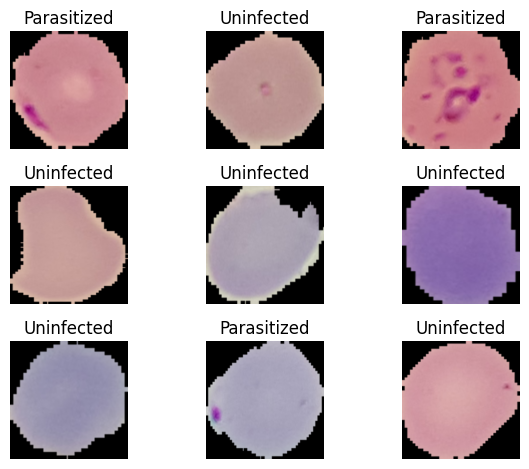

In [ ]:
import matplotlib.pyplot as plt

class_names = ["Parasitized", "Uninfected"]
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

Build model

Add data augmentaion layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

Model function

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

def build_model():
  base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
  )
  base_model.trainable = False

  inputs = Input(shape=(224, 224, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  outputs = Dense(1, activation='sigmoid')(x)

  model = Model(inputs, outputs)

  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  return model

In [ ]:
model = build_model()

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Add early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

Train model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 101s 142ms/step - accuracy: 0.8309 - loss: 0.3924 - val_accuracy: 0.9170 - val_loss: 0.1987
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 75s 136ms/step - accuracy: 0.8933 - loss: 0.2532 - val_accuracy: 0.9306 - val_loss: 0.1801
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 75s 136ms/step - accuracy: 0.9046 - loss: 0.2384 - val_accuracy: 0.9322 - val_loss: 0.1731
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - accuracy: 0.9083 - loss: 0.2294 - val_accuracy: 0.9220 - val_loss: 0.1961
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.9091 - loss: 0.2252 - val_accuracy: 0.9354 - val_loss: 0.1663
Epoch 6/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.9131 - loss: 0.2238 - val_accuracy: 0.9374 - val_loss: 0.1675
Epoch 7/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 88s 149ms/step - accuracy: 0.9116 - loss: 0.2217 - val_accuracy: 0.9385 - val_loss: 0.1648
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - accuracy: 0.9164 - loss:

Plot Accuracy & Loss over epochs

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("📈 Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("📉 Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


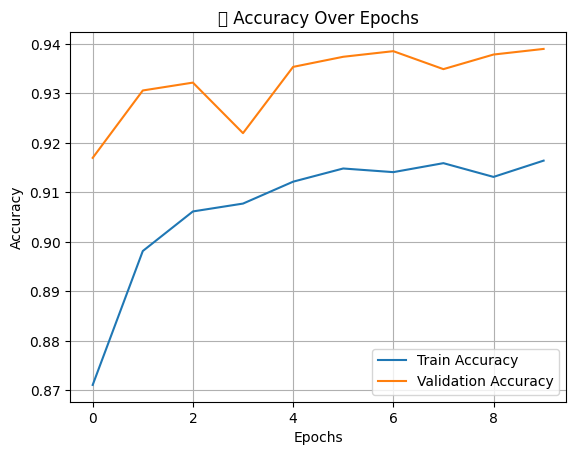

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


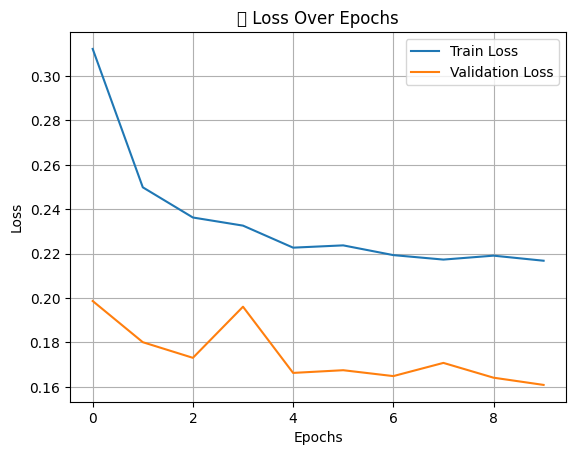

In [ ]:
plot_accuracy(history)
plot_loss(history)

Evaluate model

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {acc:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.9336 - loss: 0.1723
✅ Test Loss: 0.1661
✅ Test Accuracy: 0.9349


Classification Report

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
  preds = model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(preds)

y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report: ")
print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

Classification Report: 
              precision    recall  f1-score   support

 Parasitized       0.95      0.92      0.93      2756
  Uninfected       0.92      0.95      0.94      2756

    accuracy                           0.93      5512
   macro avg       0.94      0.93      0.93      5512
weighted avg       0.94      0.93      0.93      5512



Confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

def plot_cm(cm, class_1, class_2):
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=[class_1, class_2],
              yticklabels=[class_1, class_2])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

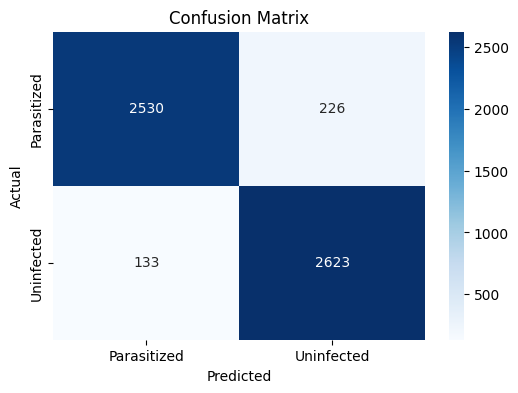

In [ ]:
plot_cm(cm, "Parasitized", "Uninfected")

Fintune ResNet50V2

In [ ]:
for layer in model.layers:
    print(layer.name)

input_layer_4
data_augmentation
resnet50v2
global_average_pooling2d_1
dropout_2
dense_2
dropout_3
dense_3


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-5)

def finetune_model(model):
  base_model = model.get_layer('resnet50v2')
  base_model.trainable = True

  for layer in base_model.layers[:-30]:
    layer.trainable = False

  model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  return model

In [ ]:
finetuned_model = finetune_model(model)

Train fine tuned model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
]

fine_tune_history = finetuned_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
)

Epoch 1/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.8996 - loss: 0.2634 - val_accuracy: 0.9510 - val_loss: 0.1437
Epoch 2/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 140s 193ms/step - accuracy: 0.9446 - loss: 0.1550 - val_accuracy: 0.9549 - val_loss: 0.1308
Epoch 3/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 113s 204ms/step - accuracy: 0.9518 - loss: 0.1392 - val_accuracy: 0.9574 - val_loss: 0.1239
Epoch 4/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 141s 201ms/step - accuracy: 0.9589 - loss: 0.1235 - val_accuracy: 0.9592 - val_loss: 0.1212
Epoch 5/5
552/552 ━━━━━━━━━━━━━━━━━━━━ 143s 203ms/step - accuracy: 0.9593 - loss: 0.1182 - val_accuracy: 0.9617 - val_loss: 0.1157


Plot Accuracy & Loss over epochs

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


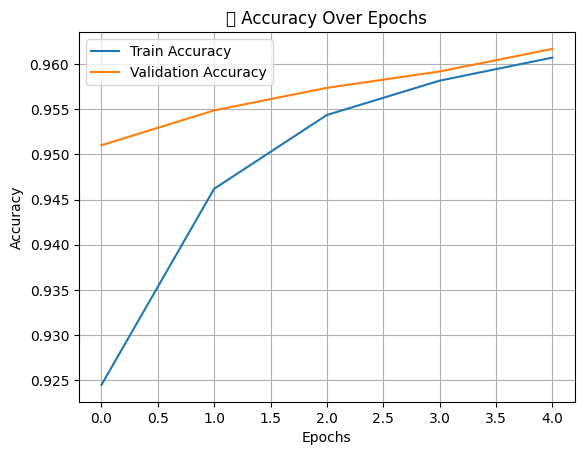

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


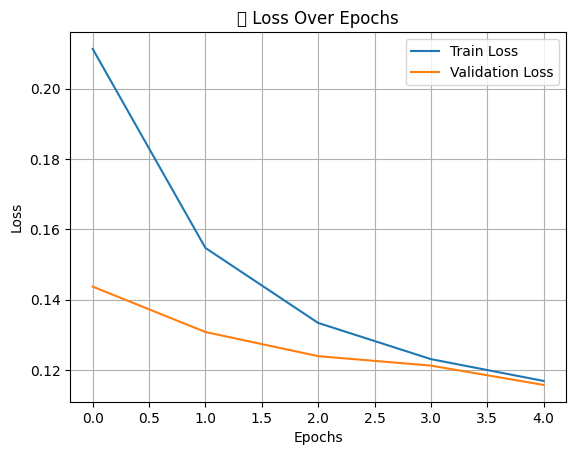

In [ ]:
plot_accuracy(fine_tune_history)
plot_loss(fine_tune_history)

Model Evaluation

In [ ]:
loss, acc = finetuned_model.evaluate(test_ds)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {acc:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9625 - loss: 0.1078
✅ Test Loss: 0.1047
✅ Test Accuracy: 0.9623


Classification report

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
  preds = finetuned_model.predict(images)
  y_true.extend(labels.numpy())
  y_pred.extend(preds)

y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report: ")
print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

Classification Report: 
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2756
  Uninfected       0.95      0.97      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



Confusion Matrix

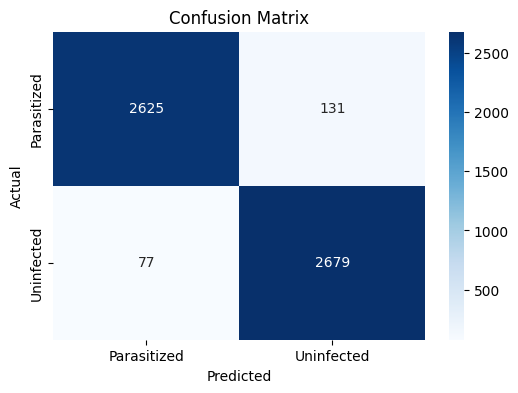

In [ ]:
fcm = confusion_matrix(y_true, y_pred)

plot_cm(fcm, "Parasitized", "Uninfected")

Save model

In [ ]:
model.save("malaria_model.keras")